#MODELO ML

##Pre procesamiento de los reviews

In [ ]:
!nvidia-smi

Wed Aug  2 22:54:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_db = pd.read_json("/content/drive/MyDrive/Henry/PROYECTO FINAL/datasets/2.json",lines=True)
df_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  150000 non-null  float64
 1   name     150000 non-null  object 
 2   time     150000 non-null  int64  
 3   rating   150000 non-null  int64  
 4   text     97352 non-null   object 
 5   pics     4747 non-null    object 
 6   resp     32916 non-null   object 
 7   gmap_id  150000 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 9.2+ MB


El df_reviews contrendra user_id, rating,text, por el momento, asi mismo eliminamos los valores nulos

In [ ]:
df_reviews=df_db.drop(columns=['name','time','pics','resp','gmap_id'])
df_reviews.dropna(subset=['text'],inplace=True)
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97352 entries, 5 to 149995
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  97352 non-null  float64
 1   rating   97352 non-null  int64  
 2   text     97352 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.0+ MB


Analizamos los reviews cantidad y tipo

In [ ]:
# Contamos cuantos datos hay por tipo de rating
conteo_ratings = df_reviews['rating'].value_counts()
print(conteo_ratings)


5    72591
1    10868
4     7953
3     3579
2     2361
Name: rating, dtype: int64


Analizaremos que tanta relación existe segun el modelo entre el sentimiento y el ranting considerando el sarcasmo y ambiguedad

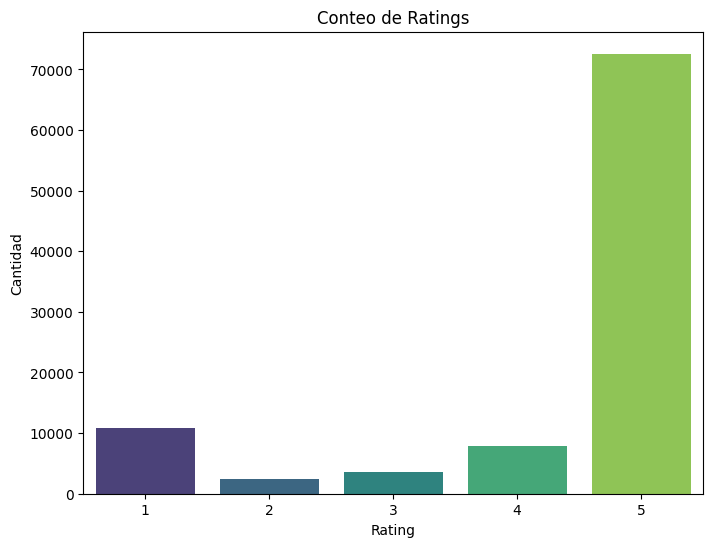

In [ ]:
#Lo graficamos para darnos una idea de las cantidades
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

# Crear la gráfica de barras usando Seaborn
sns.barplot(x=conteo_ratings.index, y=conteo_ratings.values, palette='viridis')

# Agregar etiquetas y título
plt.xlabel('Rating')
plt.ylabel('Cantidad')
plt.title('Conteo de Ratings')

# Mostrar la gráfica
plt.show()

##Probamos usanto textblob para el analsis de sentimiento (usa polaridad lexica)

In [ ]:
#Primero vamos a considerar los 3 sentimientos de acuerdo al ranting
def mapear_sentimiento(rating):
    if rating <= 2:
        return 'Negativo'
    elif rating == 3:
        return 'Neutral'
    elif rating >= 4:
        return 'Positivo'

df_reviews['Sentimiento_Mapeado'] = df_reviews['rating'].map(mapear_sentimiento)

In [ ]:
from textblob import TextBlob
def analyze_sentiment(review):
    blob = TextBlob(review)
    sentiment_score = blob.sentiment.polarity
    if sentiment_score > 0:
        return 'Positivo'
    elif sentiment_score < 0:
        return 'Negativo'
    else:
        return 'Neutral'

# veamos la predicción de textblob
df_reviews['Sentimiento_tb'] = df_reviews['text'].apply(analyze_sentiment)

In [ ]:
# Imprimir las primeras 5 filas de las columnas 'text' y 'Sentimiento' sin truncar el texto solo para esta línea
with pd.option_context('display.max_colwidth', None):
    print(df_reviews[['text', 'Sentimiento_tb','rating']].head(1))

> **Warning:** Notamos que entre el sentimiento y el rating no hay relación


Analizamos la relación entre rating y sentimiento predicho por text blob, veamoslo con una matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


confusion = confusion_matrix(df_reviews['Sentimiento_Mapeado'],df_reviews['Sentimiento_tb'])
confusion_df = pd.DataFrame(confusion, index=['Positivo', 'Neutral', 'Negativo'], columns=['Positivo', 'Neutral', 'Negativo'])

# Mostrar la matriz de confusión
accuracy = accuracy_score(df_reviews['Sentimiento_Mapeado'],df_reviews['Sentimiento_tb'])
print("Accuracy:", accuracy)

print("Matriz de Confusión:")
print(confusion_df)




Accuracy: 0.8442558961295095
Matriz de Confusión:
          Positivo  Neutral  Negativo
Positivo      6502     1618      5109
Neutral        608      479      2492
Negativo      1464     3871     75209


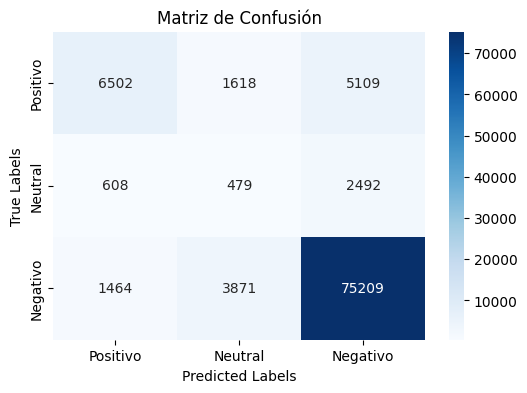

In [ ]:
# Lo graficamos
clases=['Positivo', 'Neutral', 'Negativo']
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d", xticklabels=clases, yticklabels=clases)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matriz de Confusión')
plt.show()


**CONCLUSION: El modelo no lo realiza de forma efectiva**

---



##Probamos ahora con un SVM




In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.stem.porter import PorterStemmer
import re

In [ ]:
porter_stemmer = PorterStemmer()

def stemming_tokenizer(str_input):
    # Eliminar signos de puntuación

    str_input=re.sub(r"[^\w\s]", "", str_input)
    # Eliminar números
    str_input = re.sub(r"\d+", "", str_input)

    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [word for word in words if len(word) > 1]
    words = [word.strip() for word in words]
    words = [porter_stemmer.stem(word) for word in words]

    return words

In [ ]:
#Dividimos nuestros conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(df_reviews['text'],df_reviews['Sentimiento_Mapeado'], test_size=0.2, random_state=42)
# Creamos un objeto TfidfVectorizer con la configuración de stopwords y demás

tfidf_vectorizer = TfidfVectorizer(stop_words='english', tokenizer=stemming_tokenizer, use_idf=True,max_features=1000)
# Aplicar TF-IDF a los datos de entrenamiento y prueba
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

In [ ]:
# Creamos y entrenamos nuestro el modelo SVM
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_tfidf, y_train)

# Realizamos las predicciones en el conjunto de prueba
y_pred = svm_classifier.predict(X_test_tfidf)

In [ ]:
# Calcular el accuracy (exactitud) del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calcular la precisión del modelo
precision = precision_score(y_test, y_pred, average='weighted')
print("Precisión:", precision)

# Calcular el recall (sensibilidad) del modelo
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

# Calcular el F1-score del modelo
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)




Accuracy: 0.9132556109085307
Precisión: 0.8948010479473163
Recall: 0.9132556109085307
F1-score: 0.8968617040505861


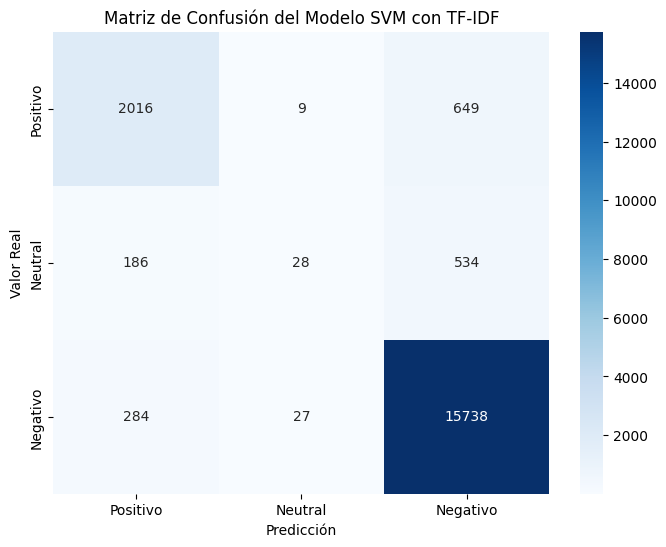

In [ ]:
confusion = confusion_matrix(y_test, y_pred)

# Crear una figura y un eje para la gráfica
plt.figure(figsize=(8, 6))

# Crear la gráfica de la matriz de confusión utilizando seaborn
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Positivo', 'Neutral', 'Negativo'], yticklabels=['Positivo', 'Neutral', 'Negativo'])

# Agregar etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión del Modelo SVM con TF-IDF')

# Mostrar la gráfica
plt.show()





**CONCLUSION: El modelo es mas efectivo el tema de neutral es porque los datos no estan equilibrados( hay pocos de una clase)**


---

##Probamos ahora con una red neuronal recurrente LSTM


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten

# Crear un diccionario para mapear las etiquetas de texto a valores numéricos
label_mapping = {"Positivo": 0, "Neutral": 1, "Negativo": 2}

# Convertir las etiquetas de texto a valores numéricos
y_train_numeric = y_train.map(label_mapping)
y_test_numeric = y_test.map(label_mapping)

# Convertir las matrices dispersas a matrices densas
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# Crear el modelo con capa Flatten
model = Sequential()
model.add(Flatten(input_shape=(X_train_dense.shape[1],)))  # input_shape=(X_train_dense.shape[1],) para entrada variable
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compilar el modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train_dense, y_train_numeric, batch_size=32, epochs=10, validation_data=(X_test_dense, y_test_numeric))



Epoch 1/10
2434/2434 [==============================] - 14s 4ms/step - loss: 0.2801 - accuracy: 0.9059 - val_loss: 0.2506 - val_accuracy: 0.9131
Epoch 2/10
2434/2434 [==============================] - 8s 3ms/step - loss: 0.2364 - accuracy: 0.9182 - val_loss: 0.2492 - val_accuracy: 0.9145
Epoch 3/10
2434/2434 [==============================] - 9s 4ms/step - loss: 0.2249 - accuracy: 0.9223 - val_loss: 0.2502 - val_accuracy: 0.9141
Epoch 4/10
2434/2434 [==============================] - 9s 4ms/step - loss: 0.2127 - accuracy: 0.9258 - val_loss: 0.2522 - val_accuracy: 0.9142
Epoch 5/10
2434/2434 [==============================] - 7s 3ms/step - loss: 0.1979 - accuracy: 0.9320 - val_loss: 0.2522 - val_accuracy: 0.9135
Epoch 6/10
2434/2434 [==============================] - 9s 4ms/step - loss: 0.1819 - accuracy: 0.9387 - val_loss: 0.2580 - val_accuracy: 0.9143
Epoch 7/10
2434/2434 [==============================] - 9s 4ms/step - loss: 0.1656 - accuracy: 0.9446 - val_loss: 0.2666 - val_accuracy

609/609 [==============================] - 2s 3ms/step


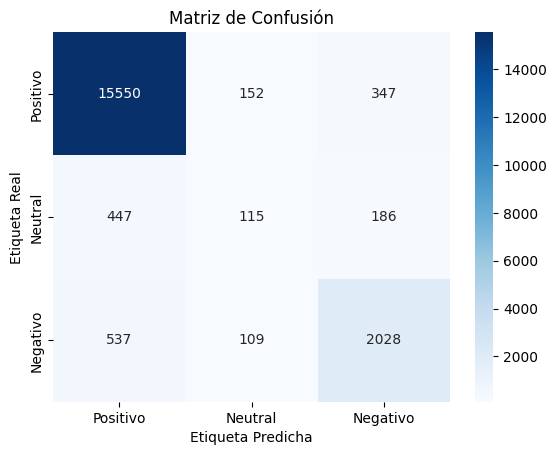

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred_prob = model.predict(X_test_dense)
y_pred = np.argmax(y_pred_prob, axis=-1)

# Crear la matriz de confusión
cm = confusion_matrix(y_test_numeric, y_pred)

# Graficar la matriz de confusión con Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Calcular métricas de evaluación
report = classification_report(y_test_numeric, y_pred, target_names=label_mapping.keys())

# Imprimir las métricas de evaluación
print("Reporte de Clasificación:")
print(report)

Reporte de Clasificación:
              precision    recall  f1-score   support

    Positivo       0.94      0.97      0.95     16049
     Neutral       0.31      0.15      0.20       748
    Negativo       0.79      0.76      0.77      2674

    accuracy                           0.91     19471
   macro avg       0.68      0.63      0.64     19471
weighted avg       0.90      0.91      0.90     19471



#PROCESO NLP